In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from pandas import Timedelta
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX


%matplotlib inline

In [2]:
# !pwd

### Data Description

Telemetry Time Series Data (PdM_telemetry.csv): It consists of hourly average of voltage, rotation, pressure, vibration collected from 100 machines for the year 2015.

Error (PdM_errors.csv): These are errors encountered by the machines while in operating condition. Since, these errors don't shut down the machines, these are not considered as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

Maintenance (PdM_maint.csv): If a component of a machine is replaced, that is captured as a record in this table. Components are replaced under two situations: 1. During the regular scheduled visit, the technician replaced it (Proactive Maintenance) 2. A component breaks down and then the technician does an unscheduled maintenance to replace the component (Reactive Maintenance). This is considered as a failure and corresponding data is captured under Failures. Maintenance data has both 2014 and 2015 records. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Failures (PdM_failures.csv): Each record represents replacement of a component due to failure. This data is a subset of Maintenance data. This data is rounded to the closest hour since the telemetry data is collected at an hourly rate.

Metadata of Machines (PdM_Machines.csv): Model type & age of the Machines.

In [3]:
telemetry_raw = pd.read_csv("Data/PdM_telemetry.csv")
errors_raw = pd.read_csv("Data/PdM_errors.csv")
maintenance_raw = pd.read_csv("Data/PdM_maint.csv")
failures_raw = pd.read_csv("Data/PdM_failures.csv")
metadata_raw = pd.read_csv("Data/PdM_machines.csv")

datasets = {"telemetry": telemetry_raw, "errors": errors_raw, "maintenance": maintenance_raw, "failures": failures_raw, "metadata": metadata_raw}

### Exploratory Data Analysis

In [4]:
for k,v in datasets.items():
    print(f"Size of {k} dataset:", v.shape)

Size of telemetry dataset: (876100, 6)
Size of errors dataset: (3919, 3)
Size of maintenance dataset: (3286, 3)
Size of failures dataset: (761, 3)
Size of metadata dataset: (100, 3)


In [5]:
telemetry_raw.head(2)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973


In [6]:
metadata_raw.head(2)

,machineID,model,age
0,1,model3,18
1,2,model4,7


In [7]:
# Makes sense to add machine metadata alongside machine telemetry to act as predictors

feature_df = pd.merge(telemetry_raw, metadata_raw, on="machineID", how = "outer")
assert feature_df.shape[0] == telemetry_raw.shape[0]
feature_df.head(2)

,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18


In [8]:
print(f"The first and last datetime for telemetry observations are {feature_df['datetime'].sort_values().min()} and {feature_df['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for error observations are {errors_raw['datetime'].sort_values().min()} and {errors_raw['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for failure observations are {failures_raw['datetime'].sort_values().min()} and {failures_raw['datetime'].sort_values().max()} respectively")
print(f"The first and last datetime for maintenance observations are {maintenance_raw['datetime'].sort_values().min()} and {maintenance_raw['datetime'].sort_values().max()} respectively")

The first and last datetime for telemetry observations are 2015-01-01 06:00:00 and 2016-01-01 06:00:00 respectively
The first and last datetime for error observations are 2015-01-01 06:00:00 and 2016-01-01 05:00:00 respectively
The first and last datetime for failure observations are 2015-01-02 03:00:00 and 2015-12-31 06:00:00 respectively
The first and last datetime for maintenance observations are 2014-06-01 06:00:00 and 2016-01-01 06:00:00 respectively


In [9]:
errors_raw.head(2) # 3919

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3


In [10]:
failures_raw.head(2) # 761

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1


In [193]:
failures_raw['datetime'] = pd.to_datetime(failures_raw['datetime'])
failures_raw['datetime'].dt.hour.unique()

# All failures are recorded either at 0600 hrs or 0300 hrs

array([6, 3], dtype=int32)

In [12]:
maintenance_raw.head(2) # 3286

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4


In [194]:
maintenance_raw['datetime'] = pd.to_datetime(maintenance_raw['datetime'])
maintenance_raw['datetime'].dt.hour.unique()

# Most maintenance happens around 0600 hrs

array([6], dtype=int32)

In [195]:
is_subset = failures_raw.isin(maintenance_raw).all().all()
print(is_subset)

# confirming if any failures are present in maintenance dataset at all or no

False


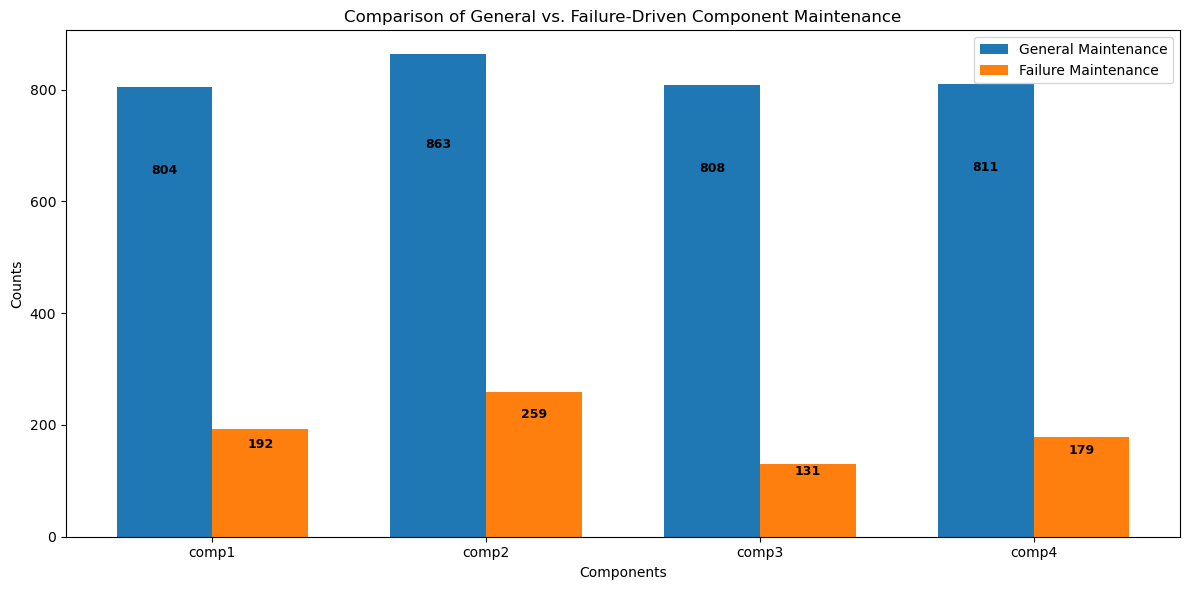

In [15]:
# Is a certain component more fragile/susceptible to maintenance? 

failure_dict = failures_raw['failure'].value_counts().to_dict()
maint_dict = maintenance_raw['comp'].value_counts().to_dict()

components = list(failure_dict.keys())
components.sort()
failure_counts = [failure_dict.get(comp) for comp in components]
maint_counts = [maint_dict.get(comp) for comp in components]

# Set positions for bars
x = np.arange(len(components))
width = 0.35  # width of the bars

# Plot bars side-by-side
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, maint_counts, width, label='General Maintenance')
bars2 = ax.bar(x + width/2, failure_counts, width, label='Failure Maintenance')

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width()/2, 0.8*height),
                xytext=(0, 0),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labeling and titles
ax.set_xlabel('Components')
ax.set_ylabel('Counts')
ax.set_title('Comparison of General vs. Failure-Driven Component Maintenance')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()

plt.tight_layout()
plt.show()

Most components are maintained at the same frequency in general. Interestingly, component 2 is the most replaced followed closely by component 1 when a failure occurs.

<BarContainer object of 5 artists>

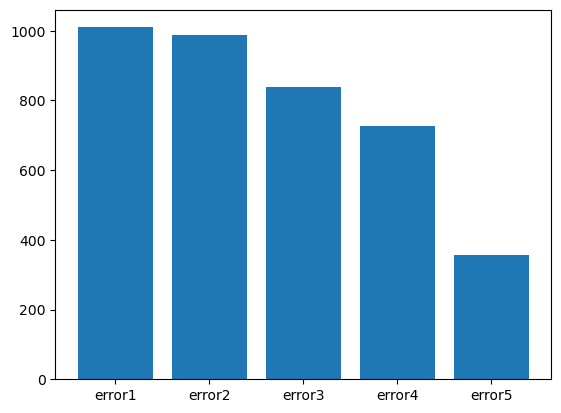

In [16]:
error_dict = errors_raw['errorID'].value_counts().to_dict()
plt.bar(error_dict.keys(),error_dict.values())

In [17]:
failure_error_maint = pd.concat([failures_raw, errors_raw, maintenance_raw])
print(failure_error_maint.shape[0] == errors_raw.shape[0] + maintenance_raw.shape[0] + failures_raw.shape[0], failure_error_maint.shape)
failure_error_maint.drop("time",axis=1,inplace=True)

True (7966, 6)


In [18]:
failure_error_maint.reset_index(inplace=True,drop=True)

In [19]:
failure_error_maint.head(2)

,datetime,machineID,failure,errorID,comp
0,2015-01-05 06:00:00,1,comp4,NaN,NaN
1,2015-03-06 06:00:00,1,comp1,NaN,NaN


In [20]:
failure_error_maint[(failure_error_maint['datetime'].duplicated() == True) & (failure_error_maint['errorID'].notna())].head()

,datetime,machineID,failure,errorID,comp
763,2015-01-04 06:00:00,1,NaN,error5,NaN
769,2015-03-05 06:00:00,1,NaN,error1,NaN
773,2015-04-19 06:00:00,1,NaN,error2,NaN
774,2015-04-19 06:00:00,1,NaN,error3,NaN
782,2015-06-18 06:00:00,1,NaN,error5,NaN


In [21]:
failure_error_maint[
    (failure_error_maint['errorID'].notna()) & 
    (failure_error_maint['comp'].notna() | failure_error_maint['failure'].notna())]

,datetime,machineID,failure,errorID,comp


Notes on data:

- Failures is structured exactly as maintenance but isn't a subset, i.e., the 2 datasets are unique. 
- No common rows between errorID, comp and failure - this implies that telemetry for an error, for a failure and before general maintenance could look very different.
- ErrorIDs can occur on any machine and any component, there's no way to tell.
- Multiple errors, failures and component maintenances can occur on the same day and time (especially since it is rounded).
- Errors recorded at any time, failures and maintenances are set.

In [22]:
# Create a labelled dataframe including associated telemetry data for each failure and error

compiled_df = pd.merge(feature_df,failure_error_maint,on=["datetime","machineID"], how="left")
print(compiled_df.shape) # higher rows than feature_df because of multiple matching entries 
compiled_df.head(2)

(877878, 11)


,datetime,machineID,volt,rotate,pressure,vibration,model,age,failure,errorID,comp
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18,NaN,NaN,NaN


In [23]:
compiled_df.describe()

,machineID,volt,rotate,pressure,vibration,age
count,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000,877878.000000
mean,50.500001,170.784239,446.552883,100.864709,40.388412,11.331142
std,28.867029,15.513778,52.712569,11.055610,5.373539,5.827578
min,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000
25%,25.000000,160.308166,412.245488,93.500230,36.778872,7.000000
50%,50.000000,170.611766,447.524832,100.428426,40.239811,12.000000
75%,76.000000,181.012842,482.148314,107.560029,43.788410,16.000000
max,100.000000,255.124717,695.020984,185.951998,76.791072,20.000000


In [24]:
compiled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877878 entries, 0 to 877877
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   877878 non-null  object 
 1   machineID  877878 non-null  int64  
 2   volt       877878 non-null  float64
 3   rotate     877878 non-null  float64
 4   pressure   877878 non-null  float64
 5   vibration  877878 non-null  float64
 6   model      877878 non-null  object 
 7   age        877878 non-null  int64  
 8   failure    761 non-null     object 
 9   errorID    3919 non-null    object 
 10  comp       2886 non-null    object 
dtypes: float64(4), int64(2), object(5)
memory usage: 73.7+ MB


In [25]:
# Ensure datetime is in correct format
compiled_df["datetime"] = pd.to_datetime(compiled_df["datetime"])

# Filter rows where an error occurred (non-null errorID)
error_timestamps = compiled_df[compiled_df["errorID"].notna()][["datetime", "machineID", "errorID"]]
failure_timestamps = compiled_df[compiled_df["failure"].notna()][["datetime", "machineID", "failure"]]

Next, we construct a dataframe with all failures and recordings 24 hours prior to visualize what machine behaviour looked like in the 24 hours before failure/error

In [26]:
# Define 24-hour window
time_window = Timedelta(hours=24)

# Create an empty list to store results
failure_telemetry = []

# Iterate over each failure timestamp
for idx, row in failure_timestamps.iterrows():
    machine = row["machineID"]
    failure_time = row["datetime"]
    
    # Extract telemetry compiled_df from 24 hours prior
    past_compiled_df = compiled_df[
        (compiled_df["machineID"] == machine) & 
        (compiled_df["datetime"] >= failure_time - time_window) & 
        (compiled_df["datetime"] < failure_time)
    ].copy()

    # Add failure compiled_df to telemetry compiled_df
    past_compiled_df["failure_time"] = failure_time
    past_compiled_df["failure"] = row["failure"]

    # Append to list
    failure_telemetry.append(past_compiled_df)

# Combine all extracted compiled_df
failure_telemetry_df = pd.concat(failure_telemetry, ignore_index=True)

In [27]:
# Define 24-hour window
time_window = Timedelta(hours=24)

# Create an empty list to store results
error_telemetry = []

# Iterate over each error timestamp
for idx, row in error_timestamps.iterrows():
    machine = row["machineID"]
    error_time = row["datetime"]
    
    # Extract telemetry compiled_df from 24 hours prior
    past_compiled_df = compiled_df[
        (compiled_df["machineID"] == machine) & 
        (compiled_df["datetime"] >= error_time - time_window) & 
        (compiled_df["datetime"] < error_time)
    ].copy()

    # Add error compiled_df to telemetry compiled_df
    past_compiled_df["error_time"] = error_time
    past_compiled_df["errorID"] = row["errorID"]

    # Append to list
    error_telemetry.append(past_compiled_df)

# Combine all extracted compiled_df
error_telemetry_df = pd.concat(error_telemetry, ignore_index=True)

In [28]:
# Find timestamps with no errors to create baseline
non_error_timestamps = compiled_df[(compiled_df["errorID"].isna()) & (compiled_df['failure'].isna()) & (compiled_df['comp'].isna())][["datetime", "machineID"]].copy()

# Randomly sample non-error timestamps
np.random.seed(42)  # For reproducibility
sample_non_error = non_error_timestamps.sample(n=len(error_telemetry_df["error_time"].unique()), replace=False)

# Create a non-error compiled_dfset with 24-hour telemetry before each sampled timestamp
baseline_telemetry = []

for idx, row in sample_non_error.iterrows():
    machine = row["machineID"]
    sample_time = row["datetime"]
    
    # Extract telemetry 24 hours before the sampled timestamp
    past_compiled_df = compiled_df[
        (compiled_df["machineID"] == machine) & 
        (compiled_df["datetime"] >= sample_time - time_window) & 
        (compiled_df["datetime"] < sample_time)
    ].copy()

    # Add metacompiled_df
    past_compiled_df["error_time"] = sample_time
    past_compiled_df["failure_time"] = sample_time
    past_compiled_df["errorID"] = "No Error"
    past_compiled_df["failure"] = "No Failure"
    past_compiled_df["label"] = "No Error"
    past_compiled_df["fail_label"] = "No Failure"

    # Store results
    baseline_telemetry.append(past_compiled_df)

# Combine all non-error cases
baseline_telemetry_df = pd.concat(baseline_telemetry, ignore_index=True)

In [29]:
# Find machines that have failures across all comps
all_failures = {'comp1', 'comp2', 'comp3', 'comp4'}
machines_with_failures = failure_telemetry_df.groupby("machineID")["failure"].unique()

# Filter machines that have experienced all failure types
machines_with_all_failures = machines_with_failures[machines_with_failures.apply(lambda x: all_failures.issubset(set(x)))].index.tolist()
print("Machines that have experienced all failure types:", machines_with_all_failures)

Machines that have experienced all failure types: [13, 17, 20, 21, 22, 23, 35, 37, 71, 73, 85, 95, 98, 99]


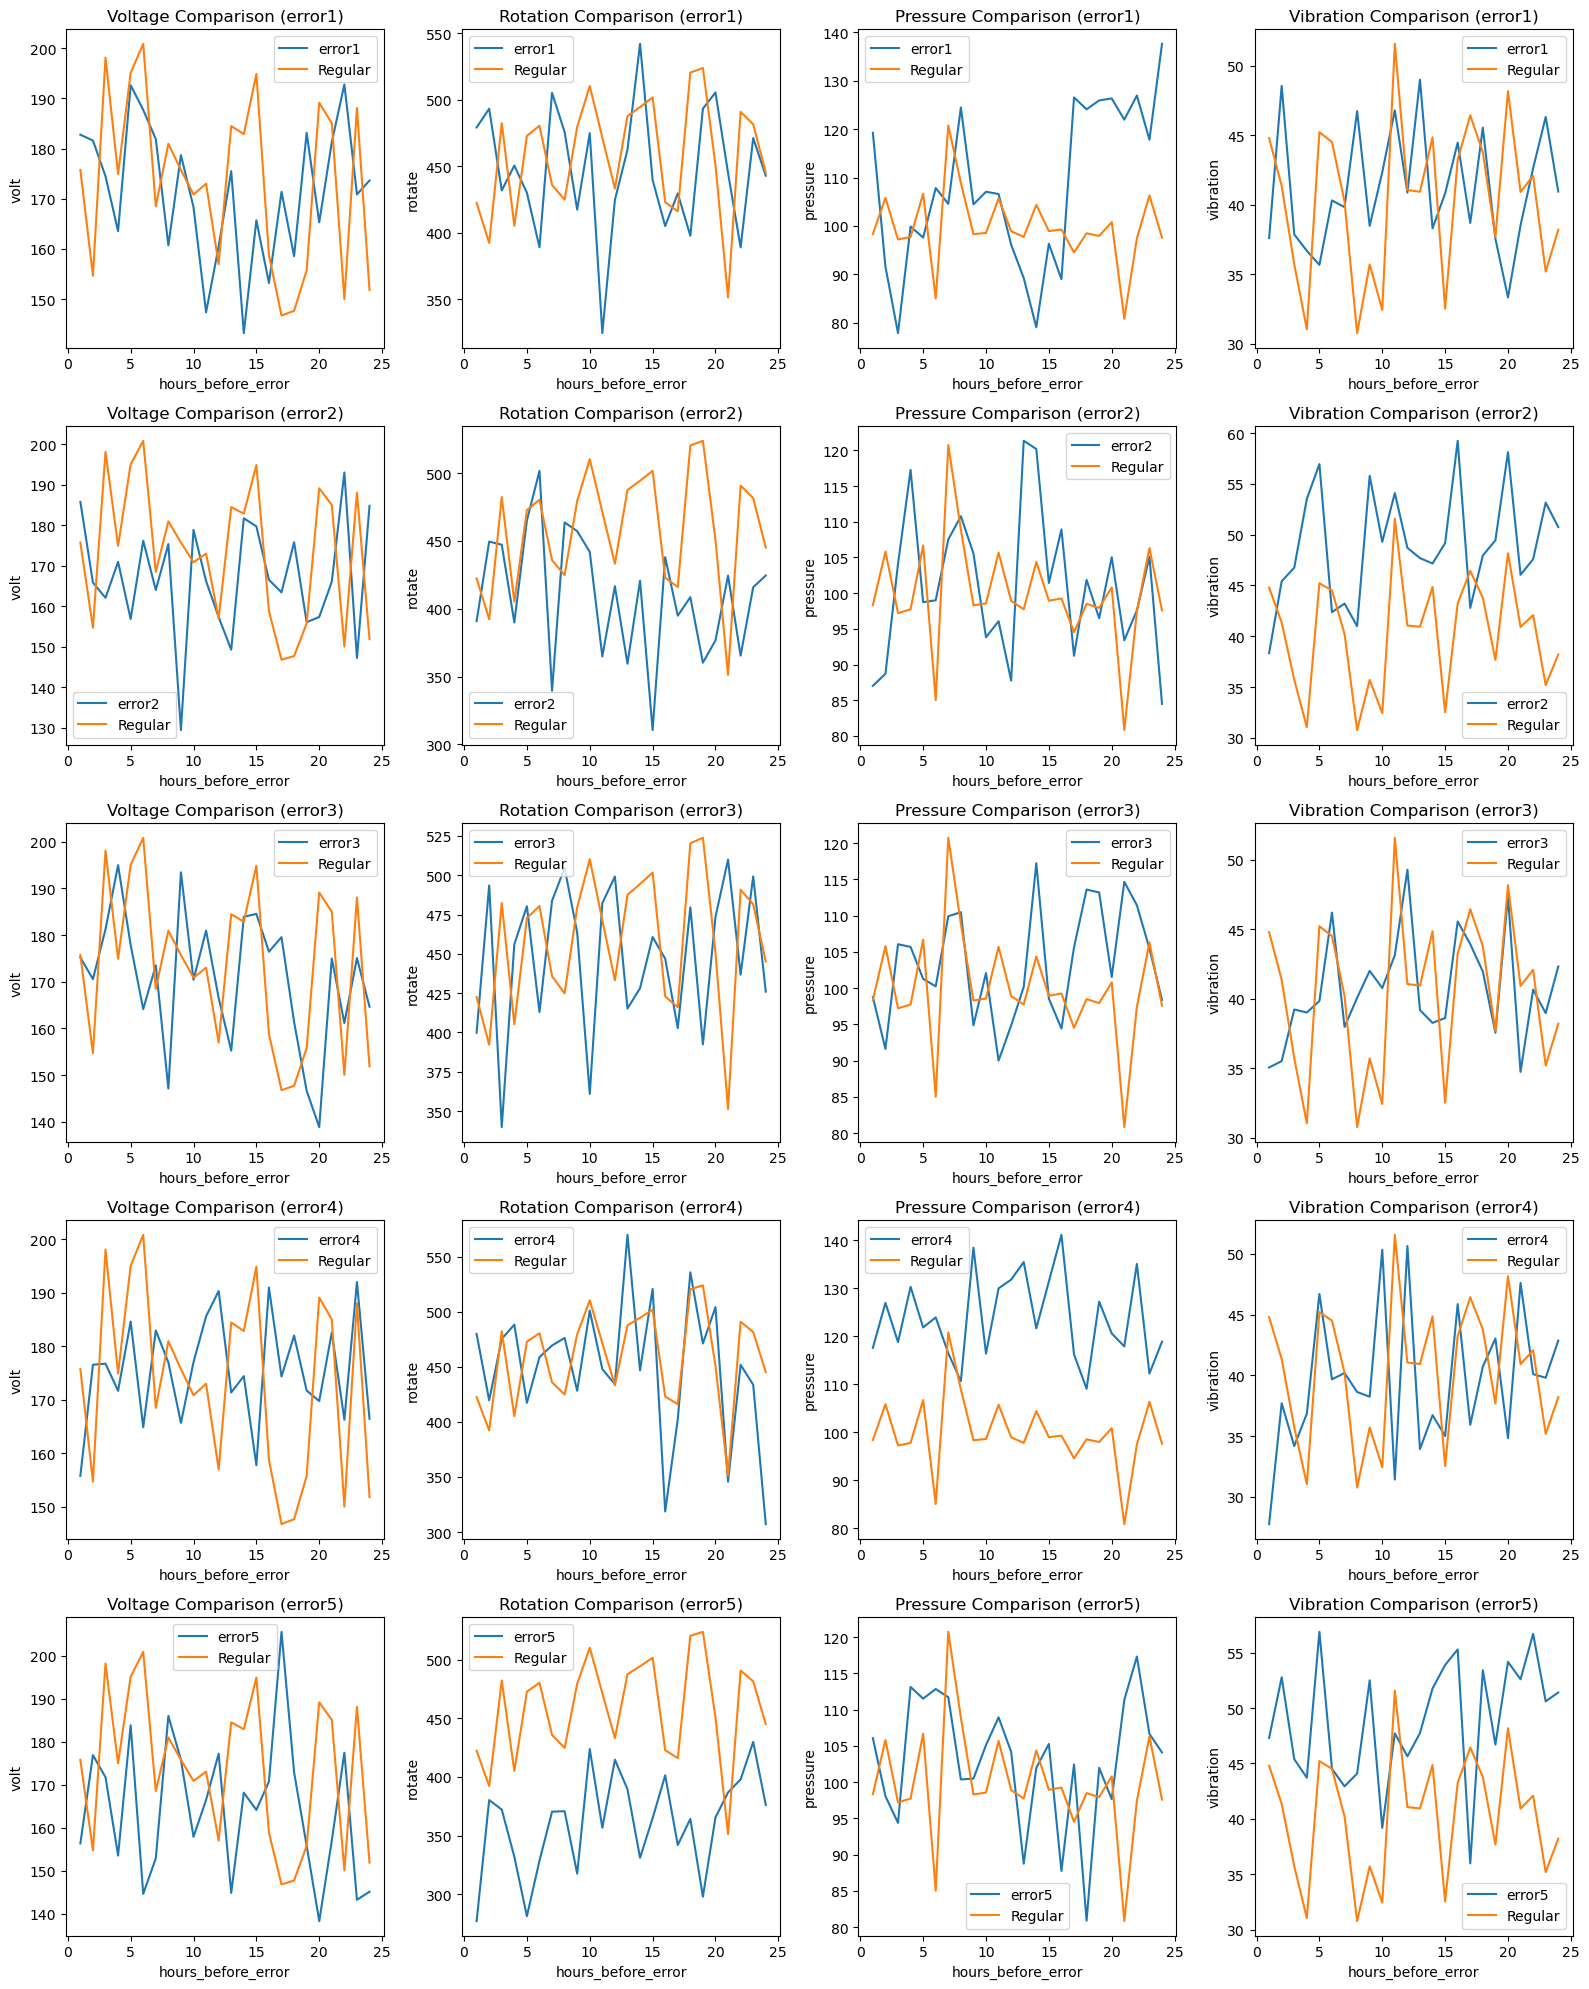

In [30]:
# Filter for Machine 37 // same machine
machine_id = 37
etd = error_telemetry_df[error_telemetry_df["machineID"] == machine_id]

# Get unique error occurrences for Machine 1
error_ids = ["error1", "error2", "error3", "error4", "error5"]
error_plot_data_list = []  # Store error data for plotting

for i, error_id in enumerate(error_ids):
    # Extract error time for this specific error ID
    sample_error_time = etd[etd['errorID'] == error_id]["error_time"].iloc[0]

    # Extract telemetry data for the error occurrence
    error_plot_data = etd[etd["error_time"] == sample_error_time].copy()
    error_plot_data["hours_before_error"] = (error_plot_data["error_time"] - error_plot_data["datetime"]).dt.total_seconds() / 3600
    error_plot_data["Condition"] = error_id  # Assign error label
    error_plot_data_list.append(error_plot_data)

# Extract baseline data (Regular operation)
baseline_times = baseline_telemetry_df[baseline_telemetry_df["machineID"] == machine_id]["error_time"].unique()
sample_baseline_time = baseline_times[0] if len(baseline_times) > 0 else None

if sample_baseline_time:
    baseline_plot_data = baseline_telemetry_df[
        (baseline_telemetry_df["machineID"] == machine_id) & 
        (baseline_telemetry_df["error_time"] == sample_baseline_time)
    ].copy()

    baseline_plot_data["hours_before_error"] = (baseline_plot_data["error_time"] - baseline_plot_data["datetime"]).dt.total_seconds() / 3600
    baseline_plot_data["Condition"] = "Regular"

# Create separate plots for each error
fig, axes = plt.subplots(len(error_plot_data_list), 4, figsize=(16, len(error_plot_data_list) * 4))

for i, error_plot_data in enumerate(error_plot_data_list):
    condition_label = error_plot_data["Condition"].iloc[0]  # Get error label

    # Voltage Plot
    sns.lineplot(data=error_plot_data, x="hours_before_error", y="volt", label=condition_label, ax=axes[i, 0])
    sns.lineplot(data=baseline_plot_data, x="hours_before_error", y="volt", label="Regular", ax=axes[i, 0])
    axes[i, 0].set_title(f"Voltage Comparison ({condition_label})")
    
    # Rotation Plot
    sns.lineplot(data=error_plot_data, x="hours_before_error", y="rotate", label=condition_label, ax=axes[i, 1])
    sns.lineplot(data=baseline_plot_data, x="hours_before_error", y="rotate", label="Regular", ax=axes[i, 1])
    axes[i, 1].set_title(f"Rotation Comparison ({condition_label})")

    # Pressure Plot
    sns.lineplot(data=error_plot_data, x="hours_before_error", y="pressure", label=condition_label, ax=axes[i, 2])
    sns.lineplot(data=baseline_plot_data, x="hours_before_error", y="pressure", label="Regular", ax=axes[i, 2])
    axes[i, 2].set_title(f"Pressure Comparison ({condition_label})")

    # Vibration Plot
    sns.lineplot(data=error_plot_data, x="hours_before_error", y="vibration", label=condition_label, ax=axes[i, 3])
    sns.lineplot(data=baseline_plot_data, x="hours_before_error", y="vibration", label="Regular", ax=axes[i, 3])
    axes[i, 3].set_title(f"Vibration Comparison ({condition_label})")


# Adjust layout for clarity
plt.tight_layout()
plt.show()


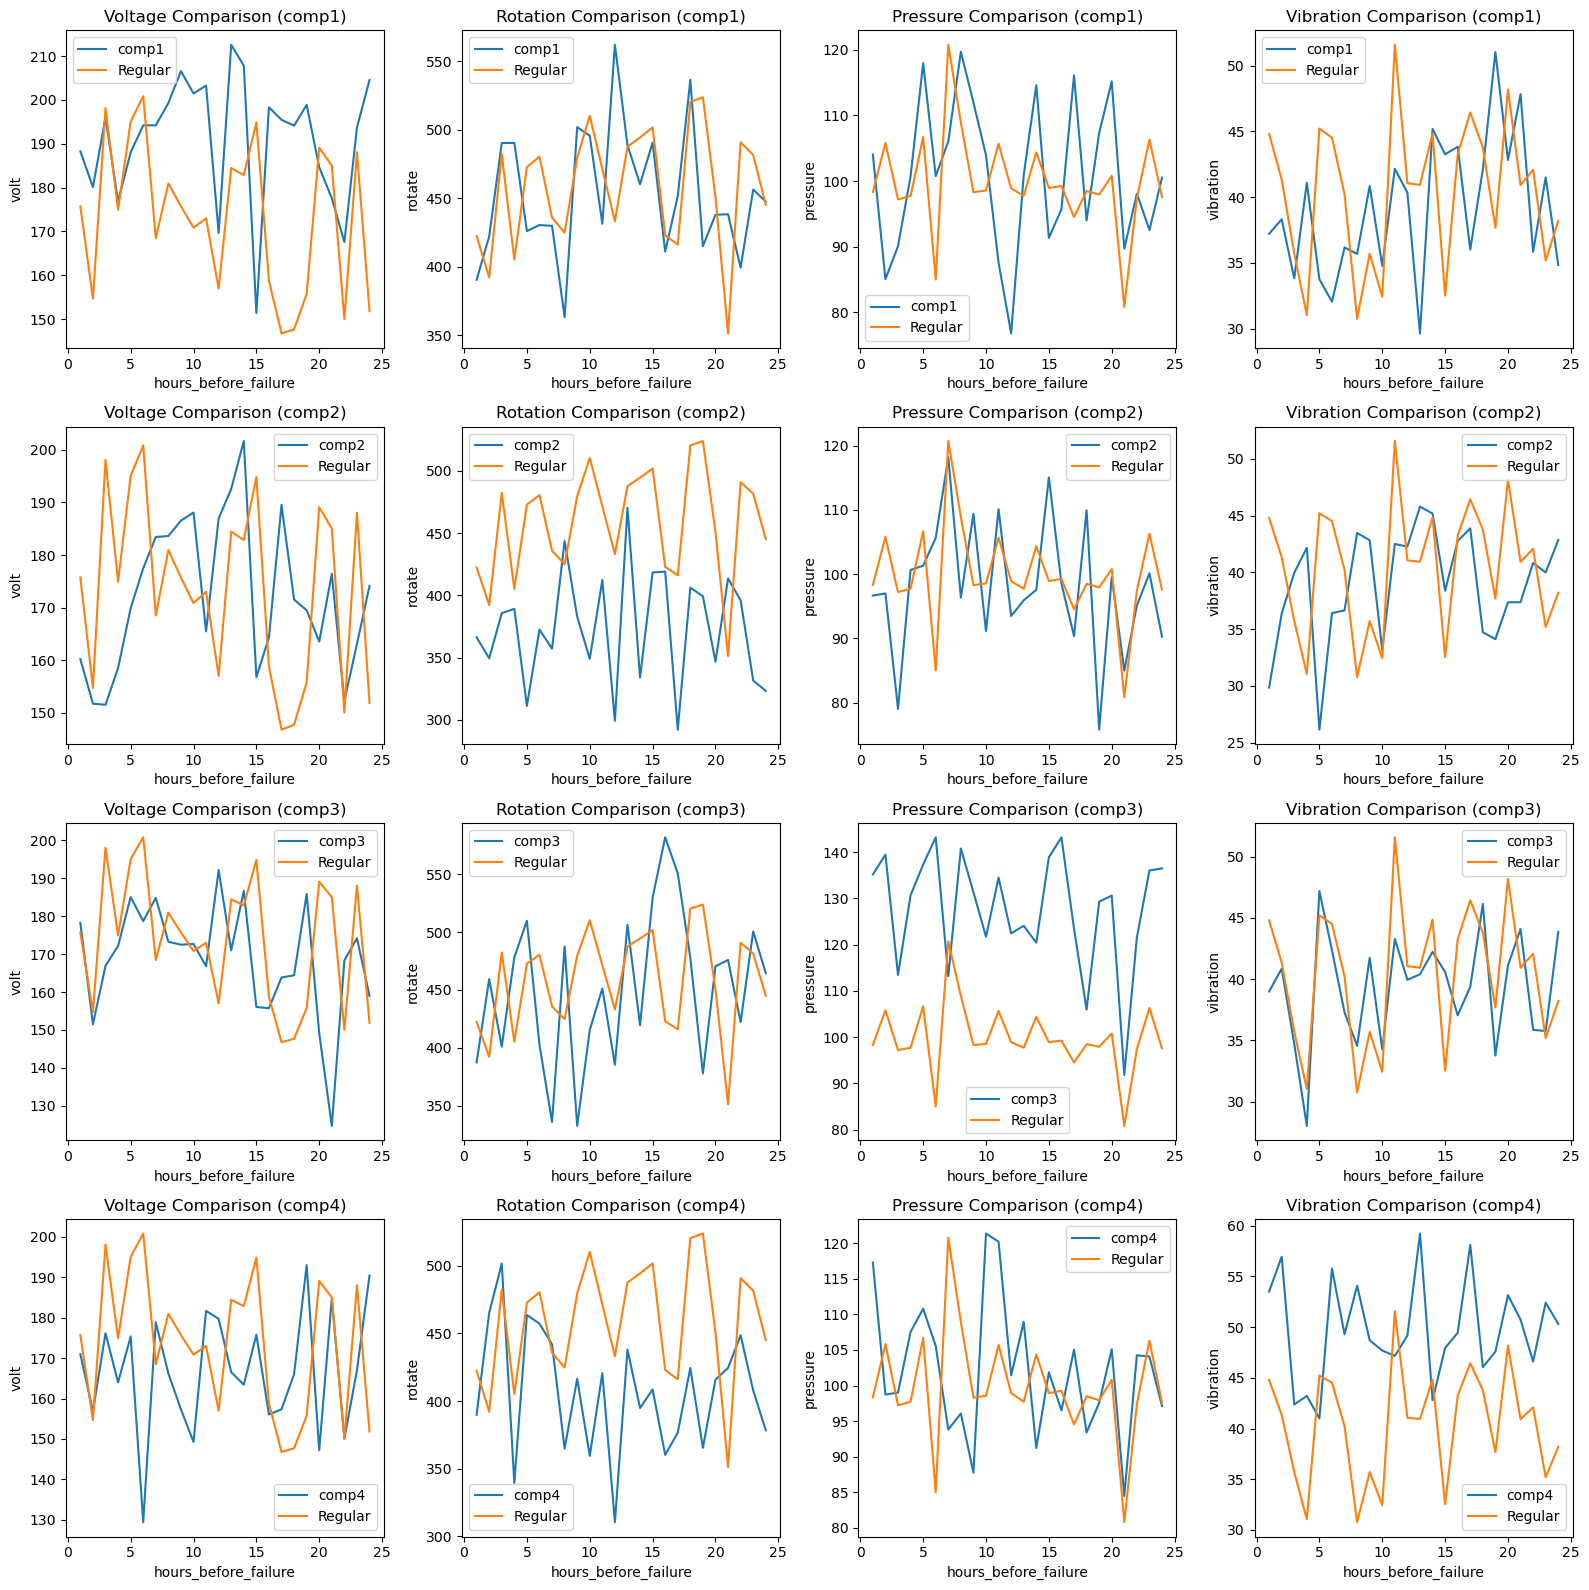

In [31]:
# Filter for Machine 37 // same machine
machine_id = 37
ftd = failure_telemetry_df[failure_telemetry_df["machineID"] == machine_id]

# Get unique failure occurrences for Machine 1
failure_ids = ['comp1', 'comp2', 'comp3', 'comp4']
failure_plot_data_list = []  # Store failure data for plotting

for i, failure_id in enumerate(failure_ids):
    # Extract failure time for this specific failure ID
    sample_failure_time = ftd[ftd['failure'] == failure_id]["failure_time"].iloc[0]

    # Extract telemetry data for the failure occurrence
    failure_plot_data = ftd[ftd["failure_time"] == sample_failure_time].copy()
    failure_plot_data["hours_before_failure"] = (failure_plot_data["failure_time"] - failure_plot_data["datetime"]).dt.total_seconds() / 3600
    failure_plot_data["Condition"] = failure_id  # Assign failure label
    failure_plot_data_list.append(failure_plot_data)

# Extract baseline data (Regular operation)
baseline_times = baseline_telemetry_df[baseline_telemetry_df["machineID"] == machine_id]["failure_time"].unique()
sample_baseline_time = baseline_times[0] if len(baseline_times) > 0 else None

if sample_baseline_time:
    baseline_plot_data = baseline_telemetry_df[
        (baseline_telemetry_df["machineID"] == machine_id) & 
        (baseline_telemetry_df["failure_time"] == sample_baseline_time)
    ].copy()

    baseline_plot_data["hours_before_failure"] = (baseline_plot_data["failure_time"] - baseline_plot_data["datetime"]).dt.total_seconds() / 3600
    baseline_plot_data["Condition"] = "Regular"

# Create separate plots for each failure
fig, axes = plt.subplots(len(failure_plot_data_list), 4, figsize=(16, len(failure_plot_data_list) * 4))

for i, failure_plot_data in enumerate(failure_plot_data_list):
    condition_label = failure_plot_data["Condition"].iloc[0]  # Get failure label

    # Voltage Plot
    sns.lineplot(data=failure_plot_data, x="hours_before_failure", y="volt", label=condition_label, ax=axes[i, 0])
    sns.lineplot(data=baseline_plot_data, x="hours_before_failure", y="volt", label="Regular", ax=axes[i, 0])
    axes[i, 0].set_title(f"Voltage Comparison ({condition_label})")
    
    # Rotation Plot
    sns.lineplot(data=failure_plot_data, x="hours_before_failure", y="rotate", label=condition_label, ax=axes[i, 1])
    sns.lineplot(data=baseline_plot_data, x="hours_before_failure", y="rotate", label="Regular", ax=axes[i, 1])
    axes[i, 1].set_title(f"Rotation Comparison ({condition_label})")

    # Pressure Plot
    sns.lineplot(data=failure_plot_data, x="hours_before_failure", y="pressure", label=condition_label, ax=axes[i, 2])
    sns.lineplot(data=baseline_plot_data, x="hours_before_failure", y="pressure", label="Regular", ax=axes[i, 2])
    axes[i, 2].set_title(f"Pressure Comparison ({condition_label})")

    # Vibration Plot
    sns.lineplot(data=failure_plot_data, x="hours_before_failure", y="vibration", label=condition_label, ax=axes[i, 3])
    sns.lineplot(data=baseline_plot_data, x="hours_before_failure", y="vibration", label="Regular", ax=axes[i, 3])
    axes[i, 3].set_title(f"Vibration Comparison ({condition_label})")


# Adjust layout for clarity
plt.tight_layout()
plt.show()

### Feature Engineering and Modelling

In [56]:
compiled_df.info() # Since failure / error are rare, there exists a class imbalance 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877878 entries, 0 to 877877
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   datetime   877878 non-null  datetime64[ns]
 1   machineID  877878 non-null  int64         
 2   volt       877878 non-null  float64       
 3   rotate     877878 non-null  float64       
 4   pressure   877878 non-null  float64       
 5   vibration  877878 non-null  float64       
 6   model      877878 non-null  object        
 7   age        877878 non-null  int64         
 8   failure    761 non-null     object        
 9   errorID    3919 non-null    object        
 10  comp       2886 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 73.7+ MB


In [73]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(compiled_df,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(compiled_df,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/801505858.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp.append(pd.pivot_table(compiled_df,
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/801505858.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp.append(pd.pivot_table(compiled_df,
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/801505858.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp.append(pd.pivot_table(compiled_df,
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/801505858.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp.append(pd.pivot_table(compiled_df,
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/801505858.py:16: FutureWarning: 'H' is deprecated and wi

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [74]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']

for col in fields:
    # Create a pivot table for the current field
    pivot = pd.pivot_table(compiled_df,
                           index='datetime',
                           columns='machineID',
                           values=col)
    # Calculate the 24-hour rolling average using the new rolling syntax
    rolling_mean = pivot.rolling(window=24).mean()
    # Resample the rolling mean into 3-hour bins and take the first value
    resampled = rolling_mean.resample('3H', closed='left', label='right').first().unstack()
    temp.append(resampled)

# Concatenate all resampled dataframes side by side
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
# Filter out rows where 'voltmean_24h' is null using ~ (bitwise NOT)
telemetry_mean_24h = telemetry_mean_24h.loc[~telemetry_mean_24h['voltmean_24h'].isnull()]

# Repeat for standard deviation
temp = []
for col in fields:
    pivot = pd.pivot_table(compiled_df,
                           index='datetime',
                           columns='machineID',
                           values=col)
    rolling_std = pivot.rolling(window=24).std()
    resampled = rolling_std.resample('3H', closed='left', label='right').first().unstack()
    temp.append(resampled)

telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[~telemetry_sd_24h['voltsd_24h'].isnull()]

# Display the first 10 rows of the rolling average dataframe
telemetry_mean_24h.head(10)

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/3062648044.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = rolling_mean.resample('3H', closed='left', label='right').first().unstack()
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/3062648044.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = rolling_mean.resample('3H', closed='left', label='right').first().unstack()
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/3062648044.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = rolling_mean.resample('3H', closed='left', label='right').first().unstack()
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/3062648044.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resample

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214
12,1,2015-01-02 21:00:00,170.556674,452.267095,98.065860,40.033247
13,1,2015-01-03 00:00:00,168.460525,451.031783,99.273286,38.903462
14,1,2015-01-03 03:00:00,169.772951,447.502464,99.005946,39.389725
15,1,2015-01-03 06:00:00,170.900562,453.864597,100.877342,38.696225
16,1,2015-01-03 09:00:00,169.533156,454.785072,100.050567,39.449734


In [75]:
telemetry_mean_24h.shape, telemetry_mean_3h.shape

((291400, 6), (292100, 6))

In [76]:
# "merge" columns of feature sets created earlier - they all are oragnized the same 
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna() 

telemetry_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.771416,446.612973,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,170.772579,446.613440,100.854547,40.384564,14.918849,49.947916,10.046687,5.002065
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.75000,2015-04-03 06:00:00,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,168.070890,441.549802,98.668589,39.354062,13.358663,44.668824,8.924317,4.460347
50%,50.50000,2015-07-03 06:00:00,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,170.210913,449.212554,100.097694,40.072752,14.853948,49.613807,9.921407,4.958594
75%,75.25000,2015-10-02 06:00:00,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,172.459612,456.368008,101.611121,40.833364,16.394764,54.821318,10.980498,5.484480
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783
std,28.86612,NaN,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,4.716970,18.074248,4.733098,2.059861,2.260726,7.682126,1.713726,0.799820


In [205]:
error_count = pd.get_dummies(compiled_df, columns = ['errorID'])
cols = ['errorID_error1', 'errorID_error2', 'errorID_error3', 'errorID_error4', 'errorID_error5']
error_count[cols] = error_count[cols].astype(int)

error_count = error_count[['errorID_error1', 'errorID_error2', 'errorID_error3', 'errorID_error4', 'errorID_error5','machineID','datetime']].groupby(['machineID', 'datetime']).sum().reset_index()
error_count.shape

(876100, 7)

In [206]:
error_count.describe()

,machineID,datetime,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5
count,876100.000000,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,2015-07-02 18:00:00,0.001153,0.001128,0.000957,0.000830,0.000406
min,1.000000,2015-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-02 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,2015-07-02 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,2015-10-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016-01-01 06:00:00,1.000000,1.000000,1.000000,1.000000,1.000000
std,28.866087,NaN,0.033934,0.033563,0.030913,0.028795,0.020154


In [207]:
error_count.head()

,machineID,datetime,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5
0,1,2015-01-01 06:00:00,0,0,0,0,0
1,1,2015-01-01 07:00:00,0,0,0,0,0
2,1,2015-01-01 08:00:00,0,0,0,0,0
3,1,2015-01-01 09:00:00,0,0,0,0,0
4,1,2015-01-01 10:00:00,0,0,0,0,0


In [208]:
temp = []
fields = ['errorID_error%d' % i for i in range(1, 6)]

for col in fields:
    # Create a pivot table for the current error column
    pivot = pd.pivot_table(error_count,
                           index='datetime',
                           columns='machineID',
                           values=col)
    # Calculate the 24-hour rolling sum
    rolling_sum = pivot.rolling(window=24).sum()
    # Resample the rolling sum into 3-hour bins and take the first value in each bin
    resampled = rolling_sum.resample('3H', closed='left', label='right').first().unstack()
    temp.append(resampled)

# Concatenate the results for all error columns side by side
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()

# Display summary statistics of the resulting dataframe
error_count.describe()

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/2294513028.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = rolling_sum.resample('3H', closed='left', label='right').first().unstack()
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/2294513028.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = rolling_sum.resample('3H', closed='left', label='right').first().unstack()
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/2294513028.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = rolling_sum.resample('3H', closed='left', label='right').first().unstack()
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/2294513028.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled =

,machineID,datetime,errorID_error1count,errorID_error2count,errorID_error3count,errorID_error4count,errorID_error5count
count,291400.00000,291400,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,2015-07-03 07:30:00,0.027649,0.027069,0.022907,0.019904,0.009753
min,1.00000,2015-01-02 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,2.000000,2.000000,2.000000,2.000000,2.000000
std,28.86612,NaN,0.166273,0.164429,0.151453,0.140820,0.098797


In [179]:
error_count.head()

,machineID,datetime,errorID_error1count,errorID_error2count,errorID_error3count,errorID_error4count,errorID_error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [167]:
# create a column for each error type 
comp_rep = pd.get_dummies(maintenance_raw.drop("time",axis=1).set_index('datetime')).reset_index() # need those 2014 values too
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']
comp_rep['datetime'] = pd.to_datetime(comp_rep['datetime'])

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
feature_df['datetime'] = pd.to_datetime(feature_df['datetime'])
comp_rep = feature_df[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')
    
comp_rep.describe()

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/2757524570.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<DatetimeArray>
['2014-12-13 06:00:00', '2015-01-05 06:00:00', '2015-01-20 06:00:00',
 '2015-03-06 06:00:00', '2015-03-21 06:00:00', '2015-06-19 06:00:00',
 '2015-07-19 06:00:00', '2015-08-03 06:00:00', '2015-09-02 06:00:00',
 '2015-10-02 06:00:00',
 ...
 '2014-09-14 06:00:00', '2015-02-12 06:00:00', '2015-03-14 06:00:00',
 '2015-03-29 06:00:00', '2015-04-13 06:00:00', '2015-04-28 06:00:00',
 '2015-07-27 06:00:00', '2015-09-10 06:00:00', '2015-09-25 06:00:00',
 '2015-10-10 06:00:00']
Length: 804, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/2757524570.

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,53.525185,51.540806,52.725962,53.834191
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.500000,32.791667,29.666667,32.291667,32.500000
75%,2015-10-02 00:00:00,75.250000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866087,62.491679,59.269254,58.873114,59.707978


In [169]:
comp_rep.shape

(876100, 6)

In [180]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
print(final_feat.shape)
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
print(final_feat.shape)
final_feat = final_feat.merge(metadata_raw, on=['machineID'], how='left')
print(final_feat.shape)

# print(final_feat.head())
final_feat.describe()

(291300, 23)
(291300, 27)
(291300, 29)


,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,errorID_error1count,errorID_error2count,errorID_error3count,errorID_error4count,errorID_error5count,comp1,comp2,comp3,comp4,age
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.771416,446.612973,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,...,0.027659,0.027075,0.022901,0.019907,0.009756,53.350748,51.318963,52.512108,53.619118,11.330000
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.000000,12.875000,6.750000
50%,50.50000,2015-07-03 06:00:00,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.625000,29.500000,32.125000,32.375000,12.000000
75%,75.25000,2015-10-02 06:00:00,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.500000,66.250000,67.000000,70.125000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.86612,NaN,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,...,0.166301,0.164446,0.151435,0.140832,0.098813,62.418063,59.140743,58.765904,59.606886,5.827625


In [187]:
# final_feat.isnull().sum()

In [189]:
failures_raw['datetime'] = pd.to_datetime(failures_raw['datetime'])

In [191]:
labeled_features = final_feat.merge(failures_raw.drop("time",axis=1), on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7)  # fill backward up to 24h

# For all categorical columns, add 'none' as a valid category
cat_columns = labeled_features.select_dtypes(include=['category']).columns
for col in cat_columns:
    labeled_features[col] = labeled_features[col].cat.add_categories('none')

labeled_features = labeled_features.fillna('none')
labeled_features.head()

/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/4099697820.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  labeled_features = labeled_features.fillna(method='bfill', limit=7)  # fill backward up to 24h


,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,errorID_error3count,errorID_error4count,errorID_error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none


In [211]:
labeled_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291341 entries, 0 to 291340
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   machineID            291341 non-null  int64         
 1   datetime             291341 non-null  datetime64[ns]
 2   voltmean_3h          291341 non-null  float64       
 3   rotatemean_3h        291341 non-null  float64       
 4   pressuremean_3h      291341 non-null  float64       
 5   vibrationmean_3h     291341 non-null  float64       
 6   voltsd_3h            291341 non-null  float64       
 7   rotatesd_3h          291341 non-null  float64       
 8   pressuresd_3h        291341 non-null  float64       
 9   vibrationsd_3h       291341 non-null  float64       
 10  voltmean_24h         291341 non-null  float64       
 11  rotatemean_24h       291341 non-null  float64       
 12  pressuremean_24h     291341 non-null  float64       
 13  vibrationmean_

In [212]:
df = labeled_features.copy()

In [266]:
len(forecast)

24

In [293]:
results_plain = {}

for machine in feature_df['machineID'].unique():
    # Subset data for the machine and sort by datetime
    df = feature_df.set_index("datetime",drop=True)
    machine_data = df[df['machineID'] == machine].sort_index()
    ts = machine_data['volt']
    
    # 2. Split train/test (time-based split)
    split_index = int(len(ts) * 0.8)
    train, test = ts.iloc[:split_index], ts.iloc[split_index:]
    
    try:
        # 3. Use auto_arima to find the best (p, d, q)
        model = pm.auto_arima(
            train, 
            start_p=0, max_p=5,
            start_q=0, max_q=5,
            seasonal=True, m =24,       # Set to True if you suspect seasonal patterns
            d=None,               # Let auto_arima determine 'd'
            trace=True,          # Set to True if you want to see verbose logs
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True         # Stepwise search to reduce computation
        )
        
        # 4. Fit final model on the training set
        model.fit(train)
        
        # 5. Forecast the length of the test set
        forecast = model.predict(n_periods=len(test))
        
        # 6. Evaluate Forecast
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        
        results_plain[machine] = {
            'order': model.order,        # (p, d, q)
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        }
        
        # 7. Optionally, plot for the first machine as an example
        if machine == df['machineID'].unique()[0]:

            resid_std = np.std(model.resid())

            noisy_forecast = forecast + np.random.normal(loc=0, scale=resid_std, size=len(forecast))

            plt.figure(figsize=(10, 4))
            plt.plot(train.index, train, label='Train')
            plt.plot(test.index, test, label='Test')
            plt.plot(test.index, forecast, label='Forecast', color='red')
            plt.plot(test.index, noisy_forecast, label='noisy Forecast', color='green')
            plt.title(f'Machine {machine} Forecast')
            plt.legend()
            plt.show()
            
    except Exception as e:
        print(f"ARIMA modelling failed for Machine {machine}: {e}")

# 8. Summarize results_plain
results_plain_df = pd.DataFrame.from_dict(results_plain, orient='index')
print(results_plain_df)
print(results_plain_df.describe())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=62516.691, Time=33.81 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=62517.192, Time=0.12 sec


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8777.348, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8766.096, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8766.408, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8775.350, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8767.443, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8760.865, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8762.667, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8762.587, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8768.283, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8758.867, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8764.410, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8764.097, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8760.668, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

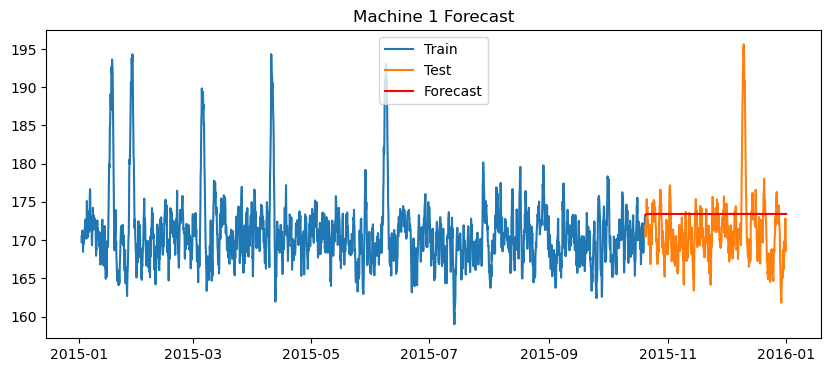

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30584.220, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8781.413, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8767.112, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8768.187, Time=1.00 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8767.865, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8781.796, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8650.021, Time=1.44 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=1.57 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.16 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8741.043, Time=0.33 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8753.683, Time=0.41 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30565.782, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8716.279, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8706.606, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.92 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8707.010, Time=0.31 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8708.609, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.85 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8708.808, Time=0.35 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8599.553, Time=0.98 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=9957.493, Time=0.56 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8622.843, Time=0.75 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8605.268, Time=

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30573.454, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8883.012, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8876.068, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8868.308, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.58 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8866.285, Time=0.44 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8866.857, Time=0.18 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.99 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=2.07 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=8867.417, Time=0.41 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=inf, Time=2.18 sec
 ARIMA

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30592.232, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8897.096, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8876.919, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8879.878, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8892.510, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8812.391, Time=1.57 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8822.169, Time=0.60 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8815.563, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8771.297, Time=2.02 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30586.708, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8722.061, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8621.062, Time=0.66 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8717.229, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8717.353, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8715.447, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8718.614, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8615.274, Time=1.52 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8611.755, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10829.079, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8617.054,

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA modelling failed for Machine 13: Length of values (1170) does not match length of index (1168)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30574.731, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8822.093, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8816.789, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8817.798, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8823.775, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8731.319, Time=1.47 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8737.200, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0] int

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA modelling failed for Machine 15: Length of values (1168) does not match length of index (1166)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30588.849, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8821.551, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.86 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8801.339, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.83 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8782.798, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.49 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8781.705, Time=0.37 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8797.893, Time=0.16 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.86 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=8659.306, Time=1.46 sec
 ARIMA(1,0,4)(0,0,0)[0]    

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30598.957, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8876.317, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8852.556, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8853.102, Time=0.83 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8852.709, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8874.998, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.95 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8742.425, Time=1.82 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8810.334, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8804.637, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8750.744, Time=

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA modelling failed for Machine 17: Length of values (1168) does not match length of index (1166)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30563.886, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8860.179, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8857.855, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.92 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8853.782, Time=0.24 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.80 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8851.336, Time=0.43 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8853.672, Time=0.15 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.65 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=1.97 sec
 ARIMA(1,0,4)(0,0,0)[0]         

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8835.321, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8817.695, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8820.026, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8833.362, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8808.558, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8800.711, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=8802.223, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8802.020, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=8804.019, Time=0.95 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=8798.737, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8806.587, Time=0.07 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=8800.250, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=8800.046, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.63 sec
 ARIMA(4,1,1)(0,0,0)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30565.497, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8752.292, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8751.320, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8747.962, Time=0.30 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.69 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8746.141, Time=0.36 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8748.529, Time=0.15 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=2.04 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=2.12 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=8740.940, Time=0.46 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=1.58 sec
 ARIMA

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30579.726, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8997.163, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8988.717, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8991.693, Time=0.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8990.157, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8992.630, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=2.45 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 5.720 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30574.526, Time=0.03 sec
 ARIMA(

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30577.370, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8835.259, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8833.053, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8837.571, Time=0.49 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8834.693, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8836.419, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.78 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 4.846 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30591.629, Time=0.02 sec
 ARIMA(

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30588.764, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8853.881, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8823.746, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8822.174, Time=0.82 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8820.020, Time=0.52 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=8820.525, Time=0.56 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=8701.661, Time=0.90 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.21 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=1.80 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=1.90 sec
 ARIMA

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30570.646, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8702.309, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8685.803, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8685.767, Time=0.49 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8676.513, Time=0.45 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=8678.486, Time=0.69 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=2.03 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.40 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=2.55 sec
 ARIMA(4,0,

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8983.229, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8952.513, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8956.628, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8981.230, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8942.838, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8939.139, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=8934.147, Time=0.27 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=8933.605, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=8935.592, Time=1.01 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=8934.848, Time=0.72 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=8931.605, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=8932.147, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=8933.592, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=8932.849, Time=0.37 sec

Best model:  ARIMA(5,1,0)(0,0,0)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30577.039, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8868.772, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8853.066, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8853.143, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8852.043, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8857.283, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8853.067, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8855.192, Time=0.14 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.95 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8744.884, Time=2.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8747.274, Time=

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA modelling failed for Machine 52: Length of values (1168) does not match length of index (1166)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30580.936, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8872.039, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8862.083, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.65 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8863.297, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8873.746, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8721.086, Time=1.86 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8785.586, Time=0.58 sec
 ARIMA(2,0,0)(0,0,0)[0] int

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30564.915, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8666.065, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8664.507, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8669.618, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.15 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8667.570, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8662.383, Time=1.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8569.577, Time=0.86 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11045.966, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8588.733, Time=0.14

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30560.597, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8897.793, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8895.000, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8899.293, Time=0.40 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8857.379, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8897.606, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.49 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8897.353, Time=0.36 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8897.849, Time=0.15 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=2.26 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.98 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time:

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30591.933, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8887.088, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8871.132, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8873.114, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8870.168, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8878.299, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.54 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8870.144, Time=0.27 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8873.673, Time=0.14 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=8862.775, Time=0.48 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=8874.741, Time=

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30567.191, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8821.254, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8818.547, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8786.386, Time=0.54 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8791.717, Time=0.62 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8812.377, Time=0.34 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8815.471, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8816.887, Time=0.40 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.95 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.83 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time:

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8681.006, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.78 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8682.913, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=24411.091, Time=0.69 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8610.348, Time=0.45 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.52 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8677.019, Time=0.40 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8680.993, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.27 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=2.09 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.88 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 9.733 seconds
Performing stepwise search to minimize

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA modelling failed for Machine 83: Length of values (1168) does not match length of index (1166)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30569.265, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8771.093, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8745.027, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8747.304, Time=0.75 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8762.649, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.66 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8591.740, Time=1.53 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8696.176, Time=0.89 sec
 ARIMA(2,0,0)(0,0,0)[0] int

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA modelling failed for Machine 88: Length of values (1168) does not match length of index (1166)
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30575.853, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8972.958, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8960.297, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8962.130, Time=0.39 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8962.120, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8968.306, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8854.764, Time=1.66 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8896.656, Time=0.84 sec
 ARIMA(2,0,0)(0,0,0)[0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30567.674, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8859.774, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8847.773, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8839.835, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.49 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8840.105, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8843.957, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8843.200, Time=0.36 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.51 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.92 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 8.40

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8761.627, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8732.541, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8734.336, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8759.627, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8732.575, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8728.782, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8730.440, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8730.381, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8734.017, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8726.782, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8732.336, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8730.541, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8728.440, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30599.197, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8882.866, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8788.423, Time=0.69 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8859.777, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8856.697, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8867.820, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=8768.722, Time=0.54 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=1.57 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.30 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8856.470, Time=0.33 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8736.392, Time=0.89 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/d4/_1hqbzm57hl3l9997c2d83t80000gn/T/ipykernel_3934/1827846148.py:45: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test - forecast) / test)) * 100


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30565.950, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8909.610, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8891.723, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8890.670, Time=0.79 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=8887.828, Time=0.45 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=8887.117, Time=0.45 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=inf, Time=2.34 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=1.88 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=8743.287, Time=2.37 sec
 ARIMA

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Prepare Data
# Assume df is your preprocessed DataFrame, 'datetime' is the index, and we have a 'machineID' column.
# We'll forecast 'voltmean_24h' for each machine.

results = {}

for machine in df['machineID'].unique():
    # Subset data for the machine and sort by datetime
    machine_data = df[df['machineID'] == machine].sort_index()
    ts = machine_data['voltmean_24h']
    
    # 2. Split train/test (time-based split)
    split_index = int(len(ts) * 0.8)
    train, test = ts.iloc[:split_index], ts.iloc[split_index:]
    
    try:
        # 3. Use auto_arima to find the best (p, d, q)
        model = pm.auto_arima(
            train, 
            start_p=0, max_p=5,
            start_q=0, max_q=5,
            seasonal=False,       # Set to True if you suspect seasonal patterns
            d=None,               # Let auto_arima determine 'd'
            trace=True,          # Set to True if you want to see verbose logs
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True         # Stepwise search to reduce computation
        )
        
        # 4. Fit final model on the training set
        model.fit(train)
        
        # 5. Forecast the length of the test set
        forecast = model.predict(n_periods=8)
        
        # 6. Evaluate Forecast
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = np.mean(np.abs((test - forecast) / test)) * 100
        
        results[machine] = {
            'order': model.order,        # (p, d, q)
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        }
        
        # 7. Optionally, plot for the first machine as an example
        if machine == df['machineID'].unique()[0]:
            plt.figure(figsize=(10, 4))
            plt.plot(train.index, train, label='Train')
            plt.plot(test.index, test, label='Test')
            plt.plot(test.index, forecast, label='Forecast', color='red')
            plt.title(f'Machine {machine} Forecast')
            plt.legend()
            plt.show()
            
    except Exception as e:
        print(f"ARIMA modelling failed for Machine {machine}: {e}")

# 8. Summarize results
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)
print(results_df.describe())


In [221]:
results_df

,order,mae,rmse,mape
1,"(1, 1, 1)",3.617437,4.811741,2.113530
2,"(3, 0, 2)",9.048094,10.859516,NaN
3,"(2, 0, 3)",2.926038,4.344559,1.698548
4,"(1, 0, 5)",3.945864,6.003765,2.248960
5,"(3, 0, 4)",6.087981,7.608022,3.512900
...,...,...,...,...
96,"(5, 0, 2)",3.063222,3.698896,1.812572
97,"(2, 0, 2)",8.351295,9.619870,NaN
98,"(5, 0, 2)",3.788696,5.462999,NaN
99,"(5, 0, 0)",2.685044,4.195970,1.539919


In [236]:
forecast

2330    171.023324
2331    171.023324
2332    171.023324
2333    171.023324
2334    171.023324
2335    171.023324
2336    171.023324
2337    171.023324
Name: predicted_mean, dtype: float64

In [238]:
model

ARIMA(order=(2, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [240]:
model.resid()

datetime
2015-01-02 06:00:00    170.666511
2015-01-02 09:00:00     -0.167069
2015-01-02 12:00:00      1.172475
2015-01-02 15:00:00      0.693165
2015-01-02 18:00:00     -1.750821
                          ...    
2015-10-19 21:00:00     -0.299760
2015-10-20 00:00:00      0.068039
2015-10-20 03:00:00     -1.922459
2015-10-20 06:00:00      2.547619
2015-10-20 09:00:00     -0.432906
Length: 2330, dtype: float64

In [274]:
# Calculate the standard deviation of the residuals from your model
resid_std = np.std(model.resid())

# model.fit(train)
        
# # 5. Forecast the length of the test set
# forecast = model.predict(n_periods=8)

# Add random noise sampled from a normal distribution with the residual std deviation
noisy_forecast = forecast + np.random.normal(loc=0, scale=resid_std, size=len(forecast))

print("Original Forecast:")
print(forecast)
print("Noisy Forecast:")
print(noisy_forecast)

Original Forecast:
2015-10-20 06:00:00    174.001380
2015-10-20 07:00:00    172.082387
2015-10-20 08:00:00    172.224378
2015-10-20 09:00:00    171.341498
2015-10-20 10:00:00    171.232470
2015-10-20 11:00:00    171.192871
2015-10-20 12:00:00    171.151065
2015-10-20 13:00:00    171.143089
2015-10-20 14:00:00    171.139277
2015-10-20 15:00:00    171.137111
2015-10-20 16:00:00    171.136553
2015-10-20 17:00:00    171.136308
2015-10-20 18:00:00    171.136216
2015-10-20 19:00:00    171.136209
2015-10-20 20:00:00    171.136225
2015-10-20 21:00:00    171.136252
2015-10-20 22:00:00    171.136284
2015-10-20 23:00:00    171.136318
2015-10-21 00:00:00    171.136352
2015-10-21 01:00:00    171.136387
2015-10-21 02:00:00    171.136421
2015-10-21 03:00:00    171.136456
2015-10-21 04:00:00    171.136491
2015-10-21 05:00:00    171.136526
Freq: h, dtype: float64
Noisy Forecast:
2015-10-20 06:00:00    156.521509
2015-10-20 07:00:00    151.248041
2015-10-20 08:00:00    168.871777
2015-10-20 09:00:00    

In [282]:
test[:24]

datetime
2015-10-20 06:00:00    159.963018
2015-10-20 07:00:00    157.625492
2015-10-20 08:00:00    160.496566
2015-10-20 09:00:00    160.244648
2015-10-20 10:00:00    167.625994
2015-10-20 11:00:00    167.418971
2015-10-20 12:00:00    161.275761
2015-10-20 13:00:00    188.872672
2015-10-20 14:00:00    171.543132
2015-10-20 15:00:00    179.252461
2015-10-20 16:00:00    156.810733
2015-10-20 17:00:00    182.183635
2015-10-20 18:00:00    179.028248
2015-10-20 19:00:00    178.000319
2015-10-20 20:00:00    184.226100
2015-10-20 21:00:00    156.494730
2015-10-20 22:00:00    176.669075
2015-10-20 23:00:00    179.949249
2015-10-21 00:00:00    166.082762
2015-10-21 01:00:00    158.927905
2015-10-21 02:00:00    191.836513
2015-10-21 03:00:00    158.976574
2015-10-21 04:00:00    170.570492
2015-10-21 05:00:00    154.446305
Name: volt, dtype: float64

In [292]:
forecast

2015-10-20 06:00:00    170.714851
2015-10-20 07:00:00    170.008259
2015-10-20 08:00:00    170.052185
2015-10-20 09:00:00    170.471323
2015-10-20 10:00:00    170.506088
                          ...    
2016-01-01 02:00:00    170.627077
2016-01-01 03:00:00    170.627077
2016-01-01 04:00:00    170.627077
2016-01-01 05:00:00    170.627077
2016-01-01 06:00:00    170.627077
Freq: h, Length: 1753, dtype: float64

In [290]:
np.mean(abs(forecast - test))

12.53043226092018

In [291]:
np.mean(abs(noisy_forecast - test))

17.32282521224585

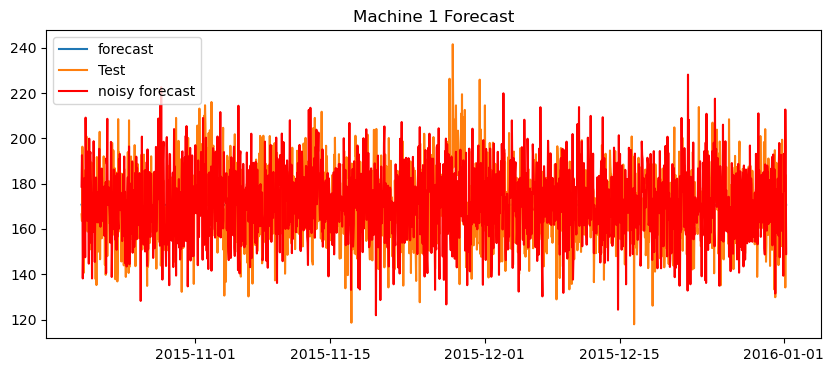

In [289]:
plt.figure(figsize=(10, 4))
plt.plot(forecast.index, forecast, label='forecast')
plt.plot(test.index, test, label='Test')
plt.plot(noisy_forecast.index, noisy_forecast, label='noisy forecast', color='red')
plt.title(f'Machine {1} Forecast')
plt.legend()
plt.show()

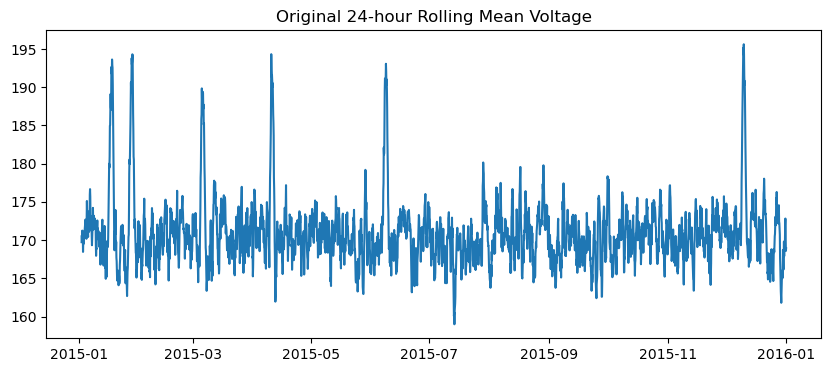

ADF Statistic: -9.153413239138171
p-value: 2.648899280788918e-15


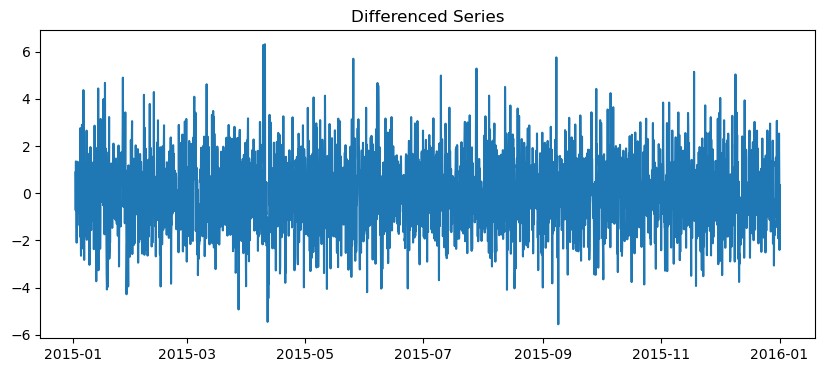

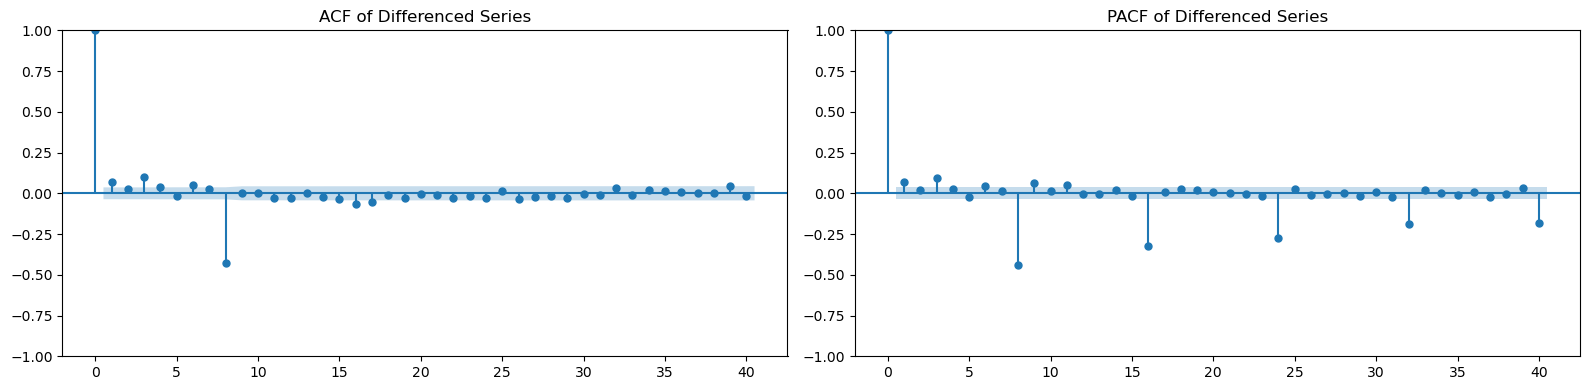

In [218]:
# Select data for one machine
machine_data = df[df['machineID'] == df['machineID'].unique()[0]].sort_index()
ts = machine_data['voltmean_24h']

# Visualize the original time series
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title('Original 24-hour Rolling Mean Voltage')
plt.show()

# Check for stationarity using the Augmented Dickey-Fuller test
result = adfuller(ts)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# If p-value is > 0.05, the series is likely non-stationary. 
# Apply first differencing to remove trend
ts_diff = ts.diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(ts_diff)
plt.title('Differenced Series')
plt.show()

# Plot ACF and PACF for the differenced series to help select ARIMA parameters
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sm.graphics.tsa.plot_acf(ts_diff, lags=40, ax=axes[0])
axes[0].set_title('ACF of Differenced Series')
sm.graphics.tsa.plot_pacf(ts_diff, lags=40, ax=axes[1])
axes[1].set_title('PACF of Differenced Series')
plt.tight_layout()
plt.show()